# Submission write-up

## Intro

Given that I got into trouble with AWS credit limits because it took me some time to get used to AWS, get initial model working and Tensorboard running, I have limited credit left for the exercise. This limitation caused by the initial struggle means I had to focus to finish only the core parts of the project and skipping further experimentation and optional tasks.

## Data Exploration

For the reasons above I skipped this part – but as it is normally essential I can give a theoretical overview of what I would look for exploring and visualizing the data.

I would check if all the classes we are trying to detect are well represented and balanced in the dataset. Are there enough pedestrians and cyclist? From all angles, full and occluded, close and in the distance? If the dataset represent average driving data, I expect to have limited data on cyclist, resulting in the models limited capacity to train to detect them.

I would also check if the dataset is balanced or not in terms of visibility and weather conditions. Are there enough daylight and dark, rainy or foggy images? Do I have those available in combination with all the classes for detection?

Also, given that we have limited number of classes, I would like to get a feel how the training data is labeled with object that are not obvious: say, are there any trams, construction vehicles or motorcyclists? Are they labeled as vehicles, or just skipped? Motorcyclist can look similar to cyclists but move very differently - sometimes even faster than other vehicles.


## Model Selection

Given my credit limitation, when it came to model selection, I decided to just try to have a set of different model architectures to see more difference based on limited training left.

I expect **EfficientDet** D1 640x640 to do fairly well as it balanced model that should do fairly well with limited fine-tuning and also should have a balanced accuracy on different scales (including smaller objects like pedestrians) thats to feature-pyramid design.

Faster **R-CNN ResNet152 V1 640x640** has to potential to reach the highest accuracy thanks to its deeper backbone and two-stage detection architecture. It should do especially well with crowded or occluded detections like pedestrians in a crowd (at least compared to other models) and smaller objects.
On the other hand, the limited training we will have can severely limit its potential, more so than the other models. It is also has the slowest inference time - but as we currently have an offline application task, this is not a problem.

**SSD MobileNet V2 FPNLite 640x640** main advantage normally should be its real-time performance / inference time. While that is a big upside when running a model on the edge (on vehicle HW) in our case that upside is limited. I expect the model to struggle more with smaller and occluded objects compared to the other ones.

## Model Training Baseline

As with the original EfficientDet model, I trained the other two models for an equal total_steps: 2000, but I have modified warmup_steps: 200 (for all 3 models). Apart from that, I have made minimal changes to the provided (in zoo) baseline config files to fit our training.  Changes include:
- _num_classes: 3_
- _batch_size: 8_
- _fine_tune_checkpoint: "checkpoint/ckpt-0"_
- _fine_tune_checkpoint_type: "detection"_
- changes to  _input_path_ and  _label_map_path_ in training and evaluation.

Note: F-CNN ResNet 152 needed reduced batch_size: 4 as it failed training with 8, due to memory limitation of the selected instance type.

## Model Training Evaluations

Here I intend to answer the assignment question, and also take a look at the training metrics seen in Tensorboard. All training notebooks and pipeline config files are in the submission folder for inspection.

**Q1: How does the validation loss compare to the training loss?**

Given that the evaluation step only happens once at the end, it is not a perfect comparison. With longer training and intermediary eval steps we could have a clearer picture. Still, after 2000 steps having a higher loss on the evaluation set than the training set is perfectly normal.

Mobilenet show a bigger difference between training and evaluation loss, meaning a worse generalizaton compared to the other models.


Mobilenet Loss:

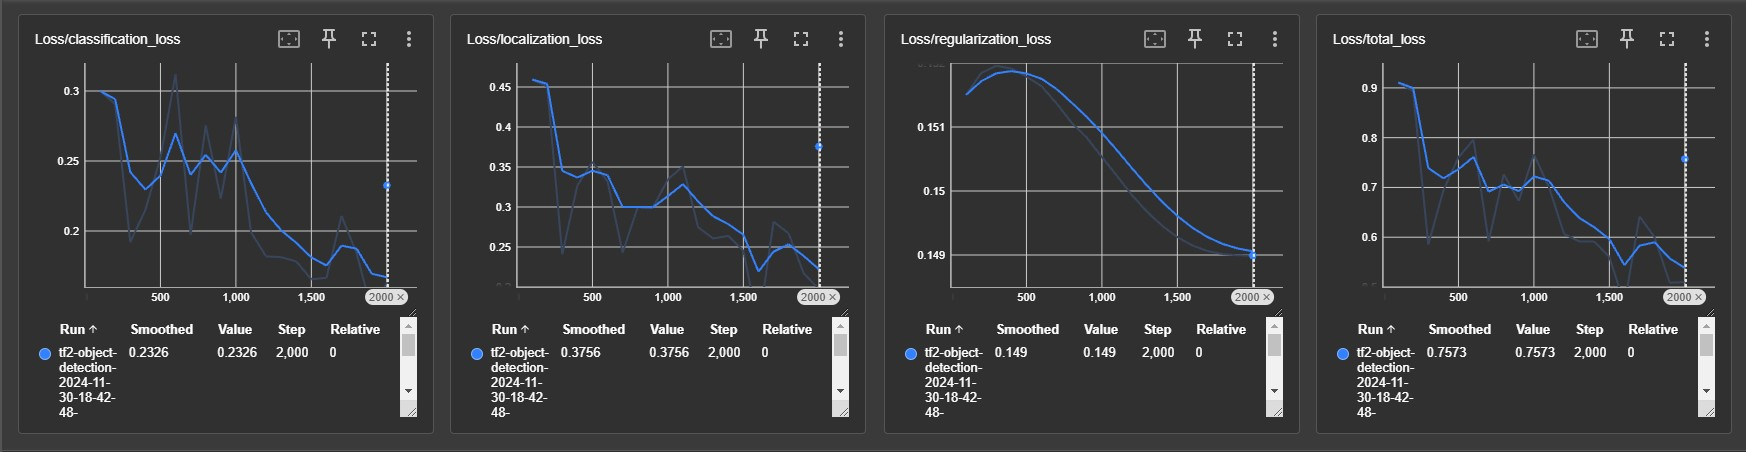

EfficientDet Loss:

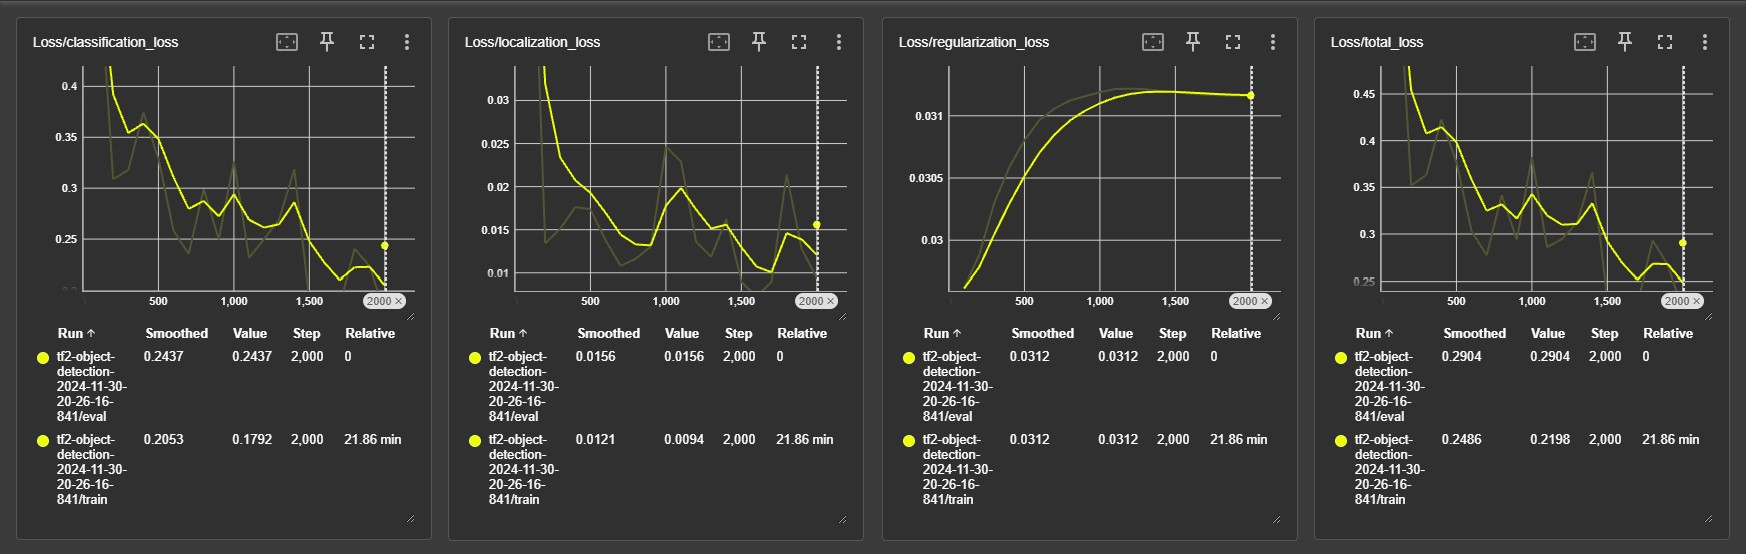

Faster R-CNN 152 Loss:

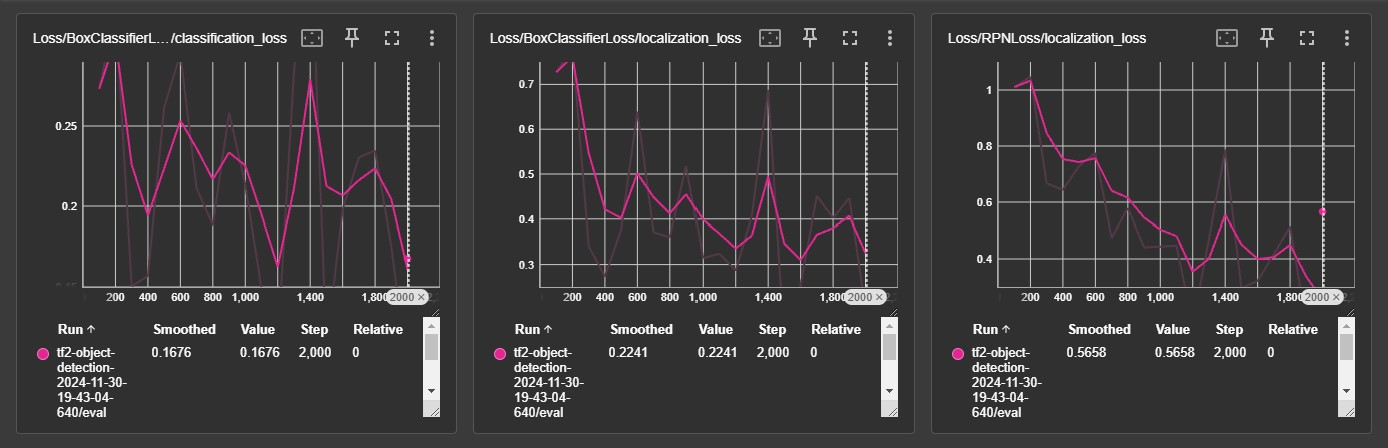

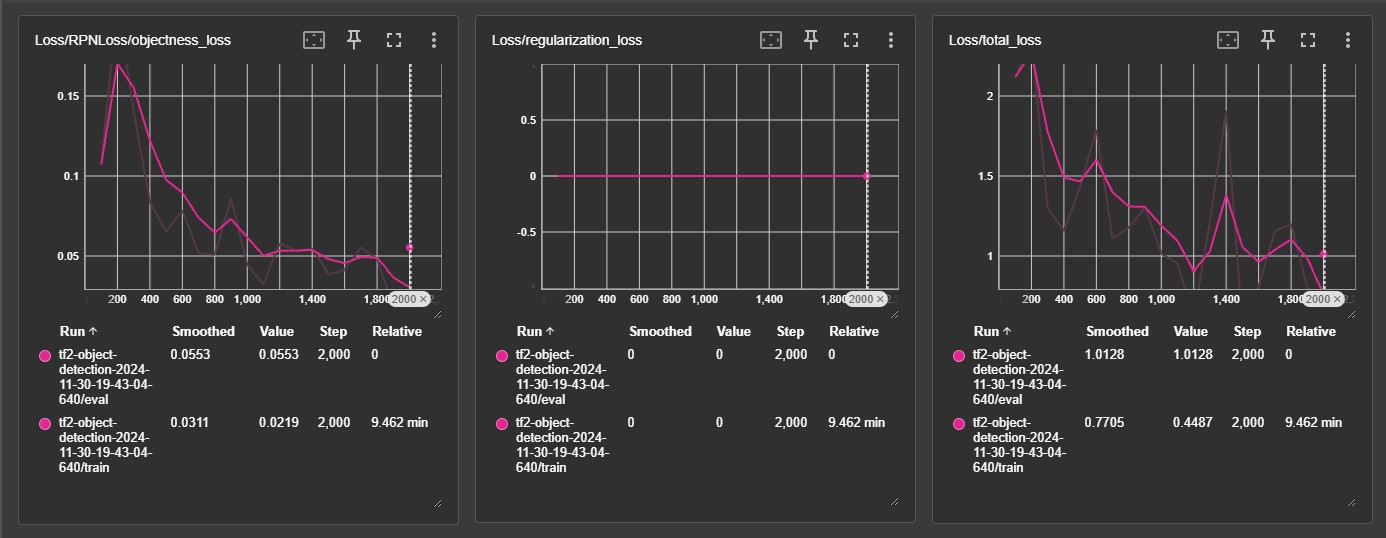

**Q2: Did you expect such behavior from the losses/metrics?**

Yes, having better performance (lower loss) on the training is to be expected. The graph on the training loss decreasing somewhat consistently is expected and good. To know more, we would need the intermediary evaluation losses, to see if that keeps improving, or the model starts to overfit (keep improving on training loss, but getting worse = higher on eval losses).


**Comparative analysis, precision and recall**
Color code:
- SSD MobileNet	    = blue
- EfficientDet		= yellow
- Faster R-CNN 152	= red / magenta

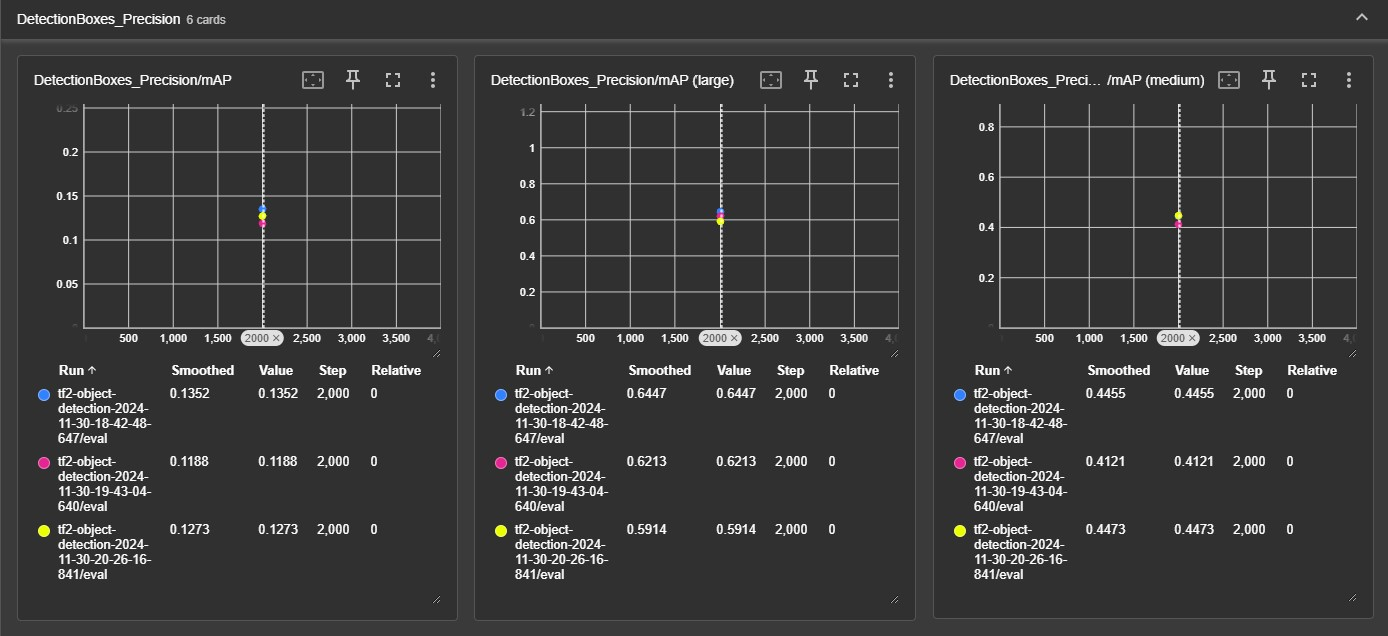

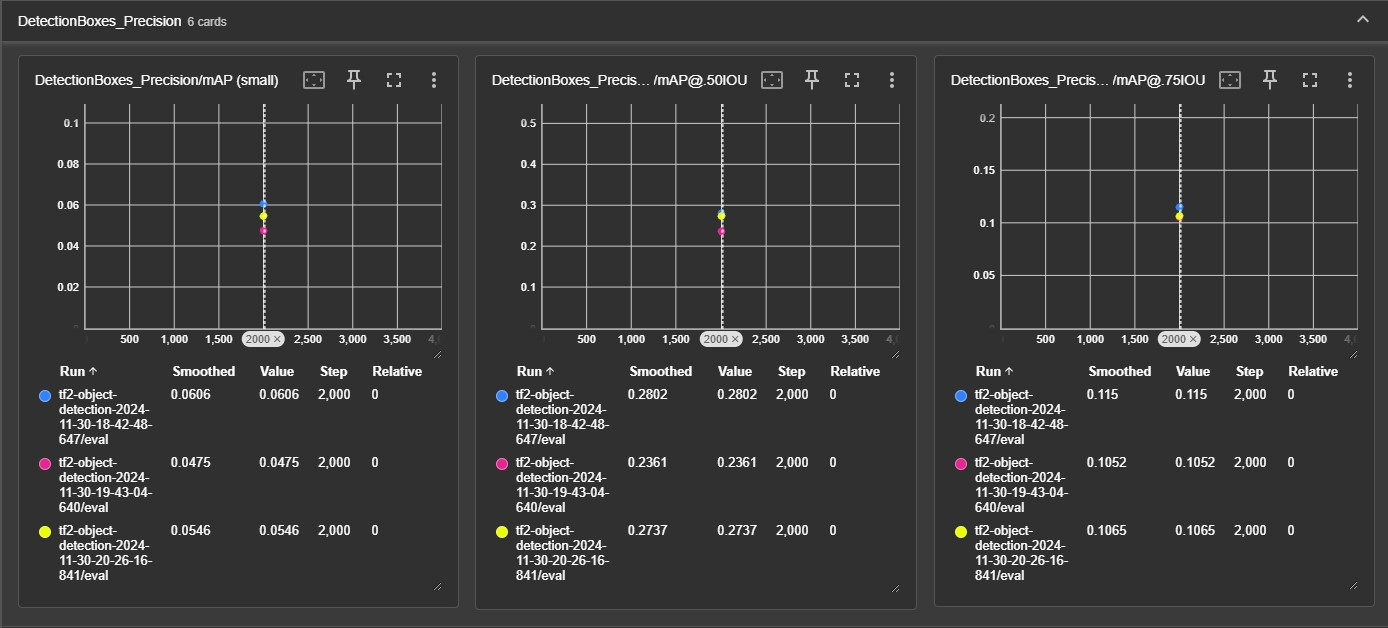

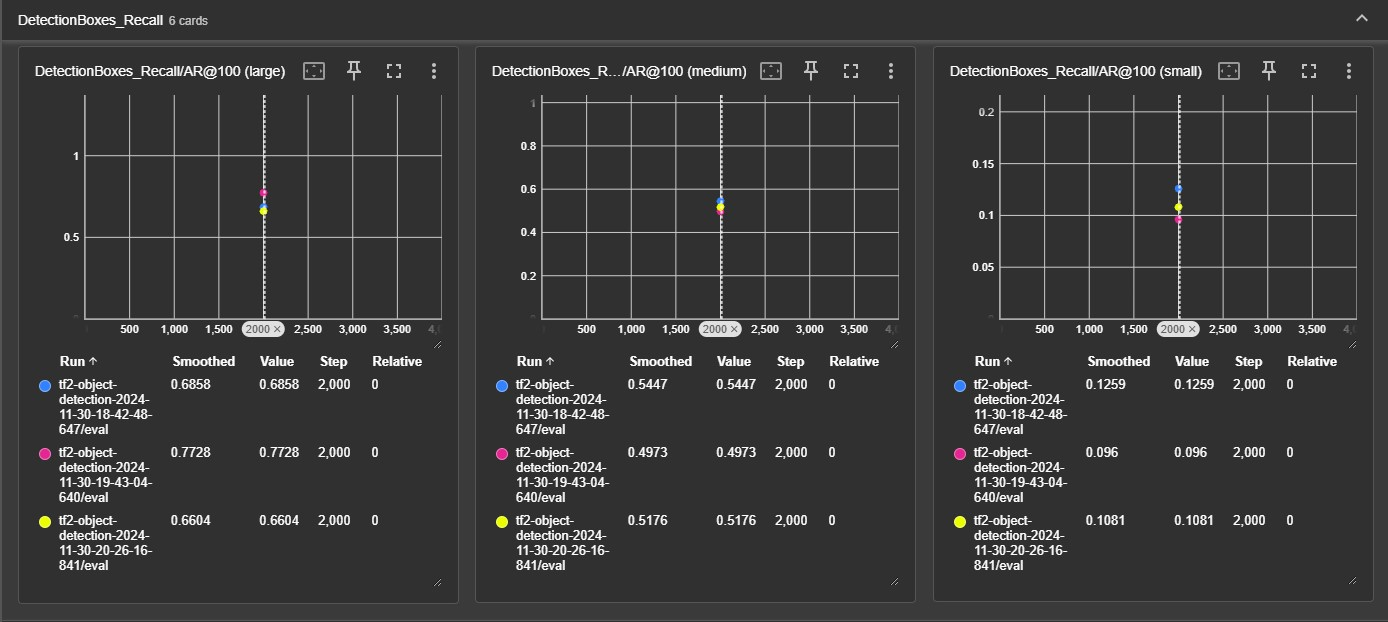

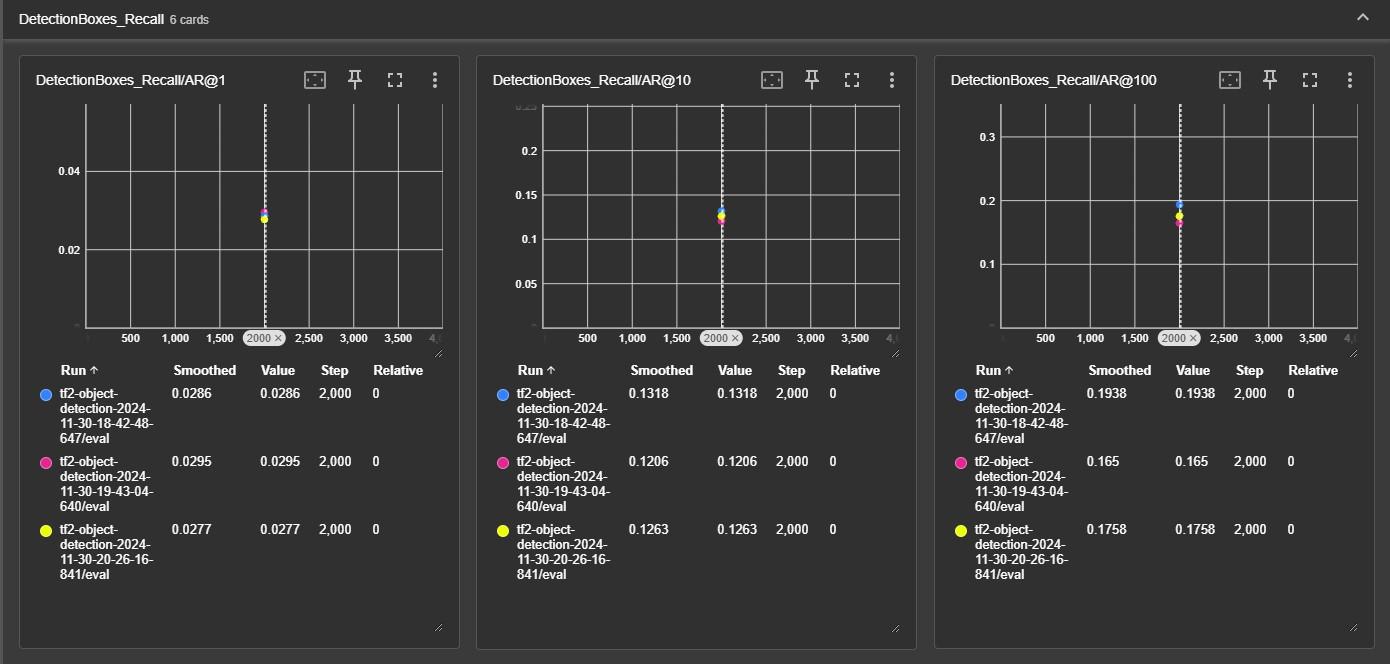

Looking at the metrics, two things stand out to me:
1. All models perform poorly with smaller objects, both for precision and recall - so much so that they are rarely detected. Large objects are obviously best, and for medium the performance is closer to large.
2. On most metrics MobileNet performed best. I expected EfficientDet to do best with its balanced model (training / accuracy). Faster R-CNN did not outperform MobileNet even on small objects, which is somewhat surprising but likely resulting in from very limited training.
Still, trying two models in Inference, the results are somewhat different from what I assumed from these metrics alone. See later.

## Improvement options

To answer submission question:

**Q3: What can you do to improve the performance of the tested models further?**


There are many steps I would try doing having more resources. I would always make adjustments one-by-one to isolate their effects (and make sure the setup is correct).


Also, as stated above I would implement intermediary evaluation steps to see what is going on.

**1. More training steps**

In general, 2000 steps are very limited. I would expect increasing training steps to 5000 and 10000 would yield better results.

The longer the training the more important to see intermediary evaluation metrics and implement early stopping, to stop training when the model starts to overfit. This should only happen when we have a good understanding of our learning rate, not to stop at local minimums the optimizer could overcome with a little more patience.

**2. Image augmentations**

In “*data_augmentation_options { … }*” I could add a host of image augmentations and see their effect. Having a proper data exploration phase should inform where to start. Generally good candidates should be:


- *random_adjust_brightness { max_delta: 0.2 }*
- *random_adjust_contrast { min_delta: 0.8 max_delta: 1.25 }*
- *random_adjust_saturation { min_delta: 0.8 max_delta: 1.25 }*


The reason being that driving datasets usually are collected in different weather and lighting conditions (day and night, sunny and overcast, rainy or foggy, sun high-low-in the eye, etc). If the dataset not have enough or balanced enough of those, the above augmentations might help to achieve better generalization.


- *random_crop_image { … }*
- *random_pad_image { … }*

These are general good baseline augmentations, but somewhat less relevant in this object detection task than it would be with classification use case.


- *random_black_patches { … }*

To simulate occlusions.

**3. Anchor_generator {anchor_scale, aspect_ratios} adjustments**

I suspect that small object detection issues maybe arise from region proposal issues stemming from anchor ratios. Changing width-to-height ratios might help with pedestrians who typically have an elongated vertical bounding box.


**4. Experimenting with optimizer.**

Trying different optimizers, learning rates and annealing techniques.

## Model Inference

While from the Tensorboard data I concluded that MobileNet offers the best performance overall, I still tried both MobileNet and Faster R-CNN for inference. To my surprise, Faster R-CNN seemingly did better: catching more objects in the distance, and more pedestrians in general. The most noticeable moment is when the video arrives to the pedestrians crossing when we arrive at a red light.


Even more interestingly, it seemed more “stable” in detecting pedestrians, meaning the MobileNet inference often looses the pedestrian for a frame and rediscovers in the next, while Faster R-CNN bounding boxes remain consistent (and tighter). I decided to include both output_{model_name}.avi files to the submission.
